In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Primero vamos a importar el dataset y lo vamos a convertir a un dataframe de pandas

In [2]:
df_heart = pd.read_csv("heart_2020_cleaned.csv")
df_heart.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


# Análisis de los datos

In [3]:
df_heart.shape

(319795, 18)

In [4]:
df_heart.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [5]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

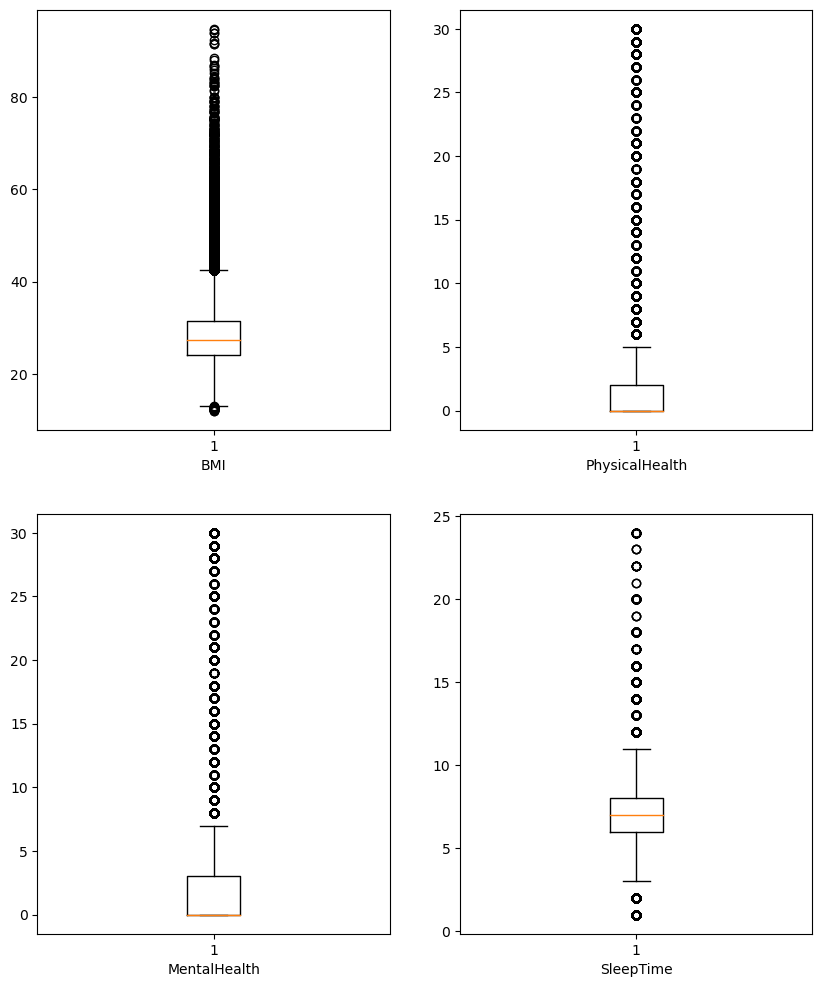

In [6]:
# Comprobamos si hay valores atípicos

fig, ((ax1, ax2),( ax3, ax4)) = plt.subplots(2,2)
fig.set_size_inches(10,12)

ax1.boxplot(df_heart["BMI"])
ax1.set_xlabel("BMI")

ax2.boxplot(df_heart["PhysicalHealth"])
ax2.set_xlabel("PhysicalHealth")

ax3.boxplot(df_heart["MentalHealth"])
ax3.set_xlabel("MentalHealth")

ax4.boxplot(df_heart["SleepTime"])
ax4.set_xlabel("SleepTime")
plt.show()

# Limpieza de los datos

Eliminamos los valores atípicos de la columna "SleepTime"

In [7]:
df_drop = df_heart[df_heart["SleepTime"] > 12].index.tolist()
df_heart.drop(df_drop, axis=0, inplace=True)

df_drop = df_heart[df_heart["SleepTime"] < 3].index.tolist()
df_heart.drop(df_drop, axis=0, inplace=True)

Procedemos a pasar todas las variables a categóricas

In [8]:
i = 0

while np.dtype("object") in df_heart.dtypes.tolist():
    if df_heart.dtypes[i] == np.dtype("O"):
        x_dummies = pd.get_dummies(df_heart[df_heart.columns[i]], prefix=df_heart.columns[i])
        df_heart.drop(df_heart.columns[i], axis=1, inplace=True)
        
        df_heart = pd.concat([df_heart, x_dummies], axis=1)  
    
    else:
        i += 1
      

In [9]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317457 entries, 0 to 319794
Data columns (total 52 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   BMI                                  317457 non-null  float64
 1   PhysicalHealth                       317457 non-null  float64
 2   MentalHealth                         317457 non-null  float64
 3   SleepTime                            317457 non-null  float64
 4   HeartDisease_No                      317457 non-null  uint8  
 5   HeartDisease_Yes                     317457 non-null  uint8  
 6   Smoking_No                           317457 non-null  uint8  
 7   Smoking_Yes                          317457 non-null  uint8  
 8   AlcoholDrinking_No                   317457 non-null  uint8  
 9   AlcoholDrinking_Yes                  317457 non-null  uint8  
 10  Stroke_No                            317457 non-null  uint8  
 11  Stroke_Yes   

In [10]:
df_heart["KidneyDisease_Yes"].value_counts()

0    305861
1     11596
Name: KidneyDisease_Yes, dtype: int64

Podemos apreciar que en nuestro dataset tenemos un total de once mil pacientes con problemas de corazón y trescientos mil que lo tienen. Al tener pocos registros de pacientes con cardiopatias esto influirá en nuesto modelo predictivo negativamente como veremos posteriormente.

In [11]:
df_heart.drop(["HeartDisease_No", "Smoking_No", "AlcoholDrinking_No", "AlcoholDrinking_No",
               "Stroke_Yes", "DiffWalking_No", "Sex_Female", "PhysicalActivity_No", "Asthma_No",
              "KidneyDisease_No", "SkinCancer_No"], axis=1, inplace=True)

In [12]:
df_heart = df_heart.reindex(columns=['BMI', 'PhysicalHealth', 'MentalHealth',
       'SleepTime', 'Smoking_Yes', 'AlcoholDrinking_Yes', 'Stroke_No',
       'DiffWalking_Yes', 'Sex_Male', 'AgeCategory_18-24', 'AgeCategory_25-29',
       'AgeCategory_30-34', 'AgeCategory_35-39', 'AgeCategory_40-44',
       'AgeCategory_45-49', 'AgeCategory_50-54', 'AgeCategory_55-59',
       'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74',
       'AgeCategory_75-79', 'AgeCategory_80 or older',
       'Race_American Indian/Alaskan Native', 'Race_Asian', 'Race_Black',
       'Race_Hispanic', 'Race_Other', 'Race_White', 'Diabetic_No',
       'Diabetic_No, borderline diabetes', 'Diabetic_Yes',
       'Diabetic_Yes (during pregnancy)', 'PhysicalActivity_Yes',
       'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good',
       'GenHealth_Poor', 'GenHealth_Very good', 'Asthma_Yes',
       'KidneyDisease_Yes', 'SkinCancer_Yes','HeartDisease_Yes'])

In [13]:
df_heart.head()

,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking_Yes,AlcoholDrinking_Yes,Stroke_No,DiffWalking_Yes,Sex_Male,AgeCategory_18-24,...,PhysicalActivity_Yes,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes,HeartDisease_Yes
0,16.60,3.0,30.0,5.0,1,0,1,0,0,0,...,1,0,0,0,0,1,1,0,1,0
1,20.34,0.0,0.0,7.0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,26.58,20.0,30.0,8.0,1,0,1,0,1,0,...,1,0,1,0,0,0,1,0,0,0
3,24.21,0.0,0.0,6.0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,23.71,28.0,0.0,8.0,0,0,1,1,0,0,...,1,0,0,0,0,1,0,0,0,0


# Modelos Predictivos

In [14]:
# Divimos los datos
x = df_heart.drop("HeartDisease_Yes", axis=1)
y = df_heart["HeartDisease_Yes"]

### Normalización de los datos utilizando MinMaxScaler

In [15]:
sc = preprocessing.normalize(x, axis=0)
x_scaled = pd.DataFrame(sc, columns=x.columns)

In [16]:
x_scaled

,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking_Yes,AlcoholDrinking_Yes,Stroke_No,DiffWalking_Yes,Sex_Male,AgeCategory_18-24,...,Diabetic_Yes (during pregnancy),PhysicalActivity_Yes,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes
0,0.001015,0.000621,0.006047,0.001231,0.002765,0.0,0.001809,0.00000,0.000000,0.0,...,0.0,0.002014,0.0,0.000000,0.000000,0.0,0.00297,0.004857,0.0,0.005811
1,0.001244,0.000000,0.000000,0.001723,0.000000,0.0,0.000000,0.00000,0.000000,0.0,...,0.0,0.002014,0.0,0.000000,0.000000,0.0,0.00297,0.000000,0.0,0.000000
2,0.001626,0.004142,0.006047,0.001969,0.002765,0.0,0.001809,0.00000,0.002575,0.0,...,0.0,0.002014,0.0,0.005406,0.000000,0.0,0.00000,0.004857,0.0,0.000000
3,0.001481,0.000000,0.000000,0.001477,0.000000,0.0,0.001809,0.00000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.003288,0.0,0.00000,0.000000,0.0,0.005811
4,0.001450,0.005799,0.000000,0.001969,0.000000,0.0,0.001809,0.00479,0.000000,0.0,...,0.0,0.002014,0.0,0.000000,0.000000,0.0,0.00297,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317452,0.001676,0.001450,0.000000,0.001477,0.002765,0.0,0.001809,0.00479,0.002575,0.0,...,0.0,0.000000,0.0,0.005406,0.000000,0.0,0.00000,0.004857,0.0,0.000000
317453,0.001825,0.000000,0.000000,0.001231,0.002765,0.0,0.001809,0.00000,0.002575,0.0,...,0.0,0.002014,0.0,0.000000,0.000000,0.0,0.00297,0.004857,0.0,0.000000
317454,0.001482,0.000000,0.000000,0.001477,0.000000,0.0,0.001809,0.00000,0.000000,0.0,...,0.0,0.002014,0.0,0.000000,0.003288,0.0,0.00000,0.000000,0.0,0.000000
317455,0.002007,0.000000,0.000000,0.002954,0.000000,0.0,0.001809,0.00000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.003288,0.0,0.00000,0.000000,0.0,0.000000


<Axes: >

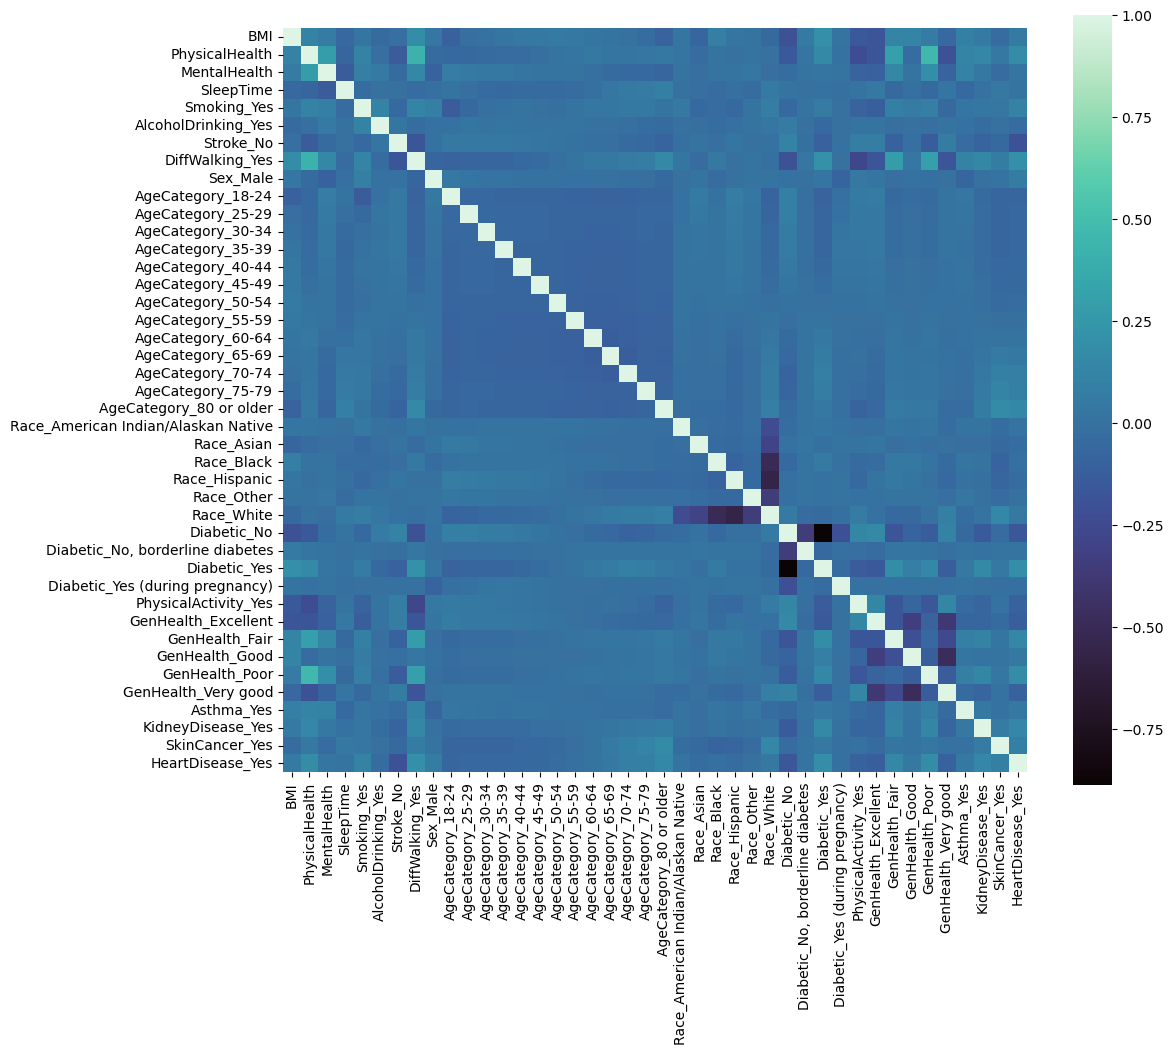

In [17]:
corr = df_heart.corr()

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr, cmap="mako", square=True)

En el gráfico anterior podemos observar que las variables que más influyen en la aparción de problemas de corazón son la diabetes, hacer deporte, la predisposición genética y la edad(a mayor edad, mayor probabilidad de problemas de corazón).

## LDA

In [18]:
lda = LinearDiscriminantAnalysis()
x_lda = lda.fit_transform(x_scaled, y)

## Separación en conjunto de entrenamiento y conjunto de testeo

In [19]:
# Conjunto de entrenamiento, conjunto de testeo

x_train, x_test, y_train, y_test = train_test_split(x_lda, y, test_size= 0.1, random_state=1)

In [20]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((285711, 1), (31746, 1), (285711,), (31746,))

In [21]:
y_test.value_counts()

0    28972
1     2774
Name: HeartDisease_Yes, dtype: int64

## Modelo de entrenamiento (Random Forest Classifier)

In [22]:
# Entrenamiento
clf = RandomForestClassifier(max_depth=4, random_state=1)

clf.fit(x_train, y_train)

RandomForestClassifier(max_depth=4, random_state=1)

In [23]:
# Testeo

y_pred = clf.predict(x_test)

In [24]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     31315
           1       0.09      0.56      0.15       431

    accuracy                           0.91     31746
   macro avg       0.54      0.74      0.55     31746
weighted avg       0.98      0.91      0.94     31746



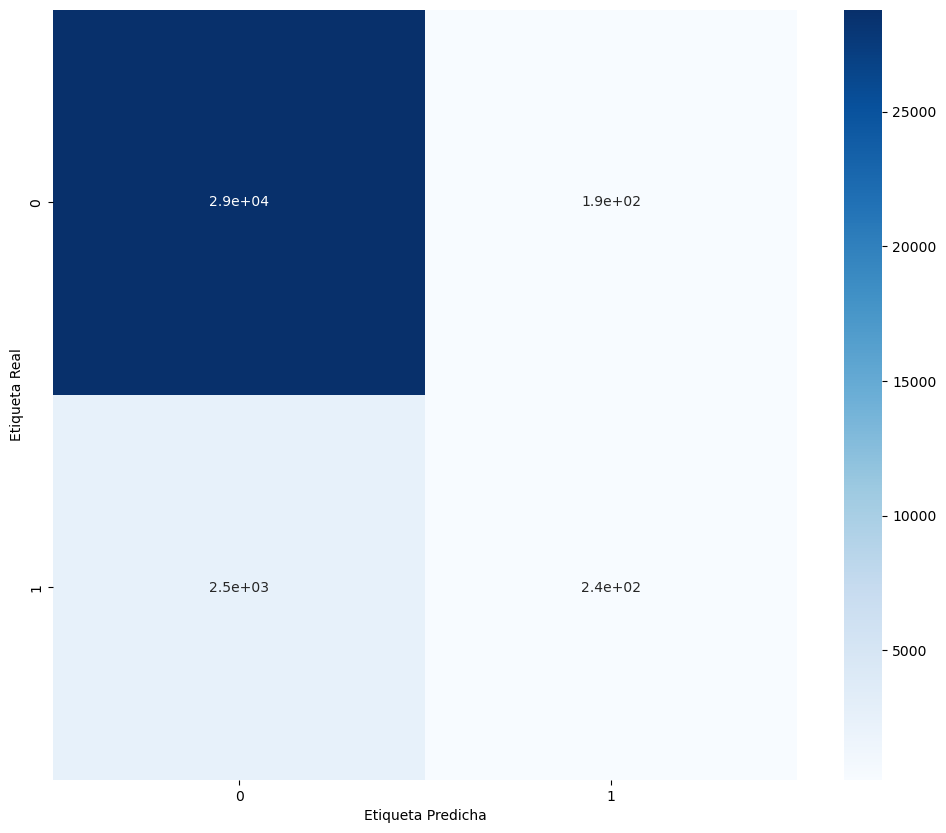

In [25]:
# Creamos una matriz de confusion y lo mostramos en un gráfico.

cf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(12,10))
shm = sns.heatmap(cf_matrix, annot=True, cmap="Blues")
shm.set_xlabel("Etiqueta Predicha")
shm.set_ylabel("Etiqueta Real")

plt.show()

## KNN

In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
knn = KNeighborsClassifier(n_neighbors=2)

In [28]:
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [29]:
y_pred = knn.predict(x_test)

In [30]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     31138
           1       0.08      0.34      0.12       608

    accuracy                           0.91     31746
   macro avg       0.53      0.63      0.54     31746
weighted avg       0.97      0.91      0.93     31746



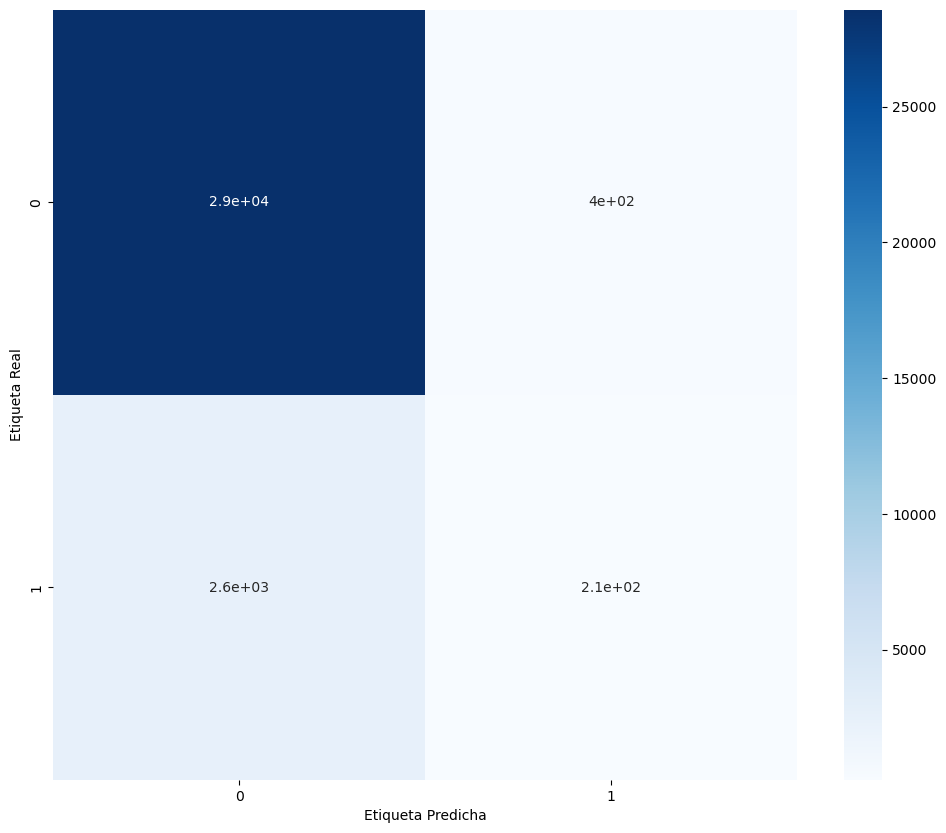

In [31]:
# Creamos una matriz de confusion y lo mostramos en un gráfico.

cf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(12,10))
shm = sns.heatmap(cf_matrix, annot=True, cmap="Blues")
shm.set_xlabel("Etiqueta Predicha")
shm.set_ylabel("Etiqueta Real")

plt.show()

## Modelo de clasificación con Keras

In [32]:
from keras import Sequential, Input
from keras.layers import Flatten, Dense

In [33]:
# Conjunto de entrenamiento, conjunto de testeo

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size= 0.1, random_state=1)

In [34]:
model = Sequential()

model.add(Dense(64, activation="relu", input_shape=[x_train.shape[1]]))

model.add(Dense(128, activation="relu"))

model.add(Dense(128, activation="relu"))

model.add(Dense(64, activation="relu"))

model.add(Dense(32, activation="relu"))

model.add(Dense(2, activation="softmax"))

In [35]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2688      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 37,922
Trainable params: 37,922
Non-traina

In [37]:
model.fit(x_train, y_train, epochs=5, validation_split=0.1)

Epoch 1/5
8036/8036 [==============================] - 9s 990us/step - loss: 0.2369 - accuracy: 0.9152 - val_loss: 0.2299 - val_accuracy: 0.9139
Epoch 2/5
8036/8036 [==============================] - 8s 940us/step - loss: 0.2298 - accuracy: 0.9152 - val_loss: 0.2310 - val_accuracy: 0.9147
Epoch 3/5
8036/8036 [==============================] - 8s 940us/step - loss: 0.2287 - accuracy: 0.9160 - val_loss: 0.2285 - val_accuracy: 0.9148
Epoch 4/5
8036/8036 [==============================] - 8s 945us/step - loss: 0.2283 - accuracy: 0.9163 - val_loss: 0.2304 - val_accuracy: 0.9141
Epoch 5/5
8036/8036 [==============================] - 8s 949us/step - loss: 0.2276 - accuracy: 0.9163 - val_loss: 0.2286 - val_accuracy: 0.9154


In [38]:
y_prob = model.predict(x_test)

993/993 [==============================] - 1s 589us/step


In [39]:
y_pred = np.argmax(y_prob, axis=1)

y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [40]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     28972
           1       0.54      0.12      0.20      2774

    accuracy                           0.91     31746
   macro avg       0.73      0.56      0.58     31746
weighted avg       0.89      0.91      0.89     31746



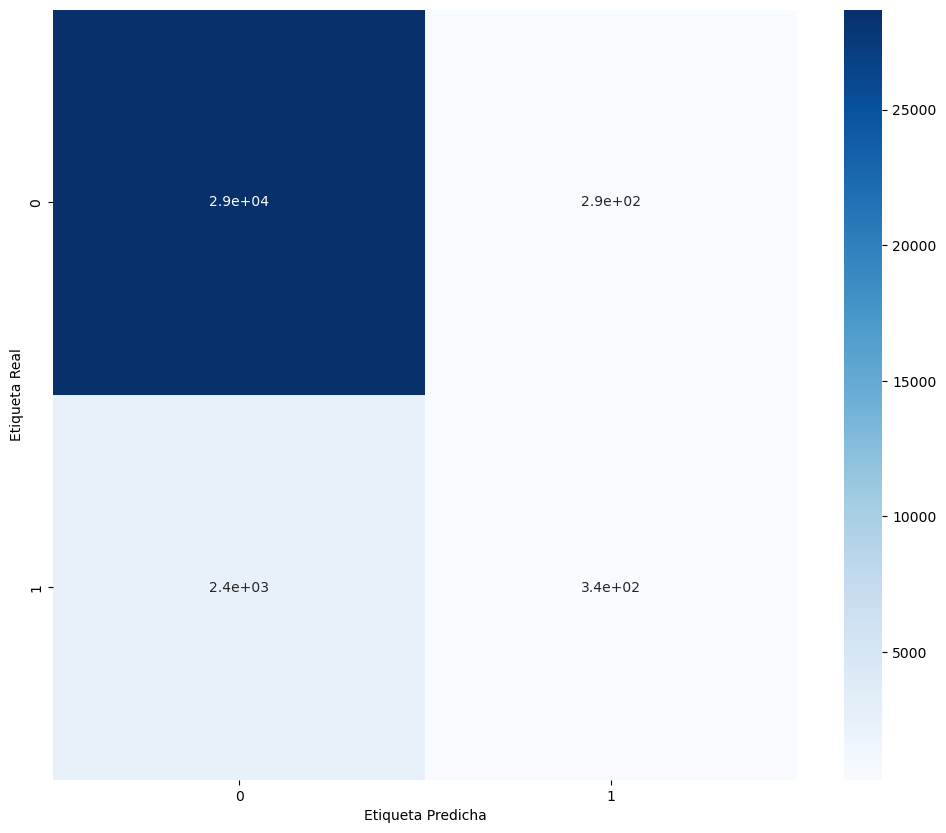

In [41]:
# Creamos una matriz de confusion y lo mostramos en un gráfico.

cf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(12,10))
shm = sns.heatmap(cf_matrix, annot=True, cmap="Blues")
shm.set_xlabel("Etiqueta Predicha")
shm.set_ylabel("Etiqueta Real")

plt.show()

# Conclusión

Los modelos de prediccón que utilizan machine learning han ofrecido una precisión casi nula al momento de predecir correctamente los pacientes que si tendrán problemas cardiacos. En cambio nuestro modelo de clasificación de Keras ha arrojado resultados mucho mejores, un 92% de aciertos en pacientes que no tienen cardiopatias y un 54% en pacientes que si presentan cardiopatias.
Esta baja precisión en los pacientes que si tienen cardiopatias se debe a los pocos datos que tenemos de estos pacientes (30 mil en total) en comparación de los datos que tenemos de los pacientes que no tienen problemas (270 mil).

En conclusión lo mejor para este caso es utilizar un modelo de aprendizaje profundo y aumentar los datos que tenemos de los pacientes con problemas cartdiopáticos para mejorar nuestros resultados futuros.